In [1]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

tree_depth = 7
trees_in_forest = 1000

train_set = pd.read_csv('Data/train.csv')
test_set = pd.read_csv('Data/test.csv')

train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


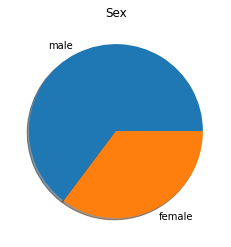

In [2]:
sex_stat = train_set.Sex.value_counts()
sex_labels = sex_stat.index
plt.pie(sex_stat, labels = sex_labels, shadow=True)
plt.title('Sex')
plt.show()

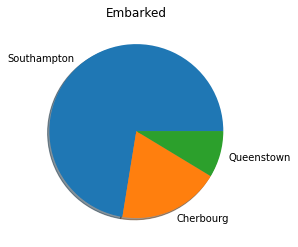

In [3]:
embarked_stat = train_set.Embarked.value_counts()
embarked_labels = ['Southampton', 'Cherbourg', 'Queenstown']
plt.pie(embarked_stat, labels = embarked_labels, shadow=True)
plt.title('Embarked')
plt.show()

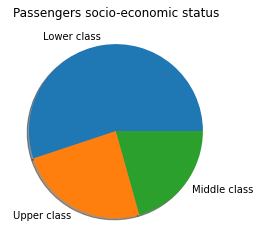

In [4]:
pclass_stat = train_set.Pclass.value_counts()
pclass_labels = ['Lower class', 'Upper class', 'Middle class']
plt.pie(pclass_stat, labels = pclass_labels, shadow=True)
plt.title('Passengers socio-economic status')
plt.show()

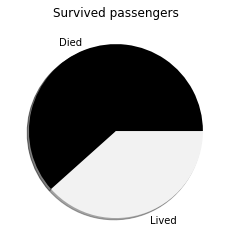

In [5]:
survived_stat = train_set.Survived.value_counts()
survived_labels = ['Died', 'Lived']
survived_colors = ['black', '#f2f2f2']
plt.pie(survived_stat, labels = survived_labels, colors = survived_colors, shadow=True)
plt.title('Survived passengers')
plt.show()

<AxesSubplot:>

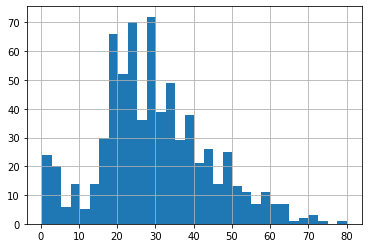

In [6]:
train_set['Age'].hist(bins=32)

In [7]:
# All names in the dataset have format "Surname, Title. Name"
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

In [8]:
titles = sorted(set([x for x in train_set.Name.map(lambda x: get_title(x))]))
print('Different titles found on the dataset:', len(titles))
print(titles)

Different titles found on the dataset: 17
['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']


In [9]:
# Normalize the titles, returning 'Mr', 'Master', 'Miss' or 'Mrs'
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady', 'Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [10]:
train_set['Title'] = train_set['Name'].map(lambda x: get_title(x))
test_set['Title'] = test_set['Name'].map(lambda x: get_title(x))

In [11]:
train_set['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [12]:
train_set['Title'] = train_set.apply(replace_titles, axis=1)
test_set['Title'] = test_set.apply(replace_titles, axis=1)

In [13]:
train_set['Title']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886      Mr
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

<AxesSubplot:ylabel='Title'>

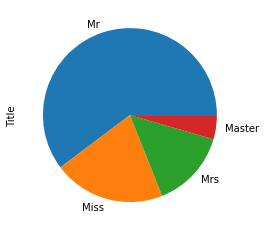

In [14]:
train_set.Title.value_counts().plot(kind='pie')

In [15]:
def data_prep(set):
    set = set.drop(columns=['Name', 'Ticket', 'Fare', 'Cabin', 'PassengerId'])
    set = set.dropna()
    set['Sex'] = set['Sex'].replace('male', 1)
    set['Sex'] = set['Sex'].replace('female', 0)
    set['Title'] = set['Title'].replace('Mr', 0)
    set['Title'] = set['Title'].replace('Master', 1)
    set['Title'] = set['Title'].replace('Miss', 2)
    set['Title'] = set['Title'].replace('Mrs', 3)
    set['Embarked'] = set['Embarked'].replace('C', 0)
    set['Embarked'] = set['Embarked'].replace('S', 1)
    set['Embarked'] = set['Embarked'].replace('Q', 2)
    set['Age'] = set['Age'].astype(np.int64)
    return set

def data_prep_family_drop(set):
    set = set.drop(columns=['SibSp','SibSp','Title'])
    return set

In [16]:
train_set = data_prep(train_set)
train_set

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,0,3,1,22,1,0,1,0
1,1,1,0,38,1,0,0,3
2,1,3,0,26,0,0,1,2
3,1,1,0,35,1,0,1,3
4,0,3,1,35,0,0,1,0
...,...,...,...,...,...,...,...,...
885,0,3,0,39,0,5,2,3
886,0,2,1,27,0,0,1,0
887,1,1,0,19,0,0,1,2
889,1,1,1,26,0,0,0,0


In [17]:
test_set = data_prep(test_set)
test_set

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,3,1,34,0,0,2,0
1,3,0,47,1,0,1,3
2,2,1,62,0,0,2,0
3,3,1,27,0,0,1,0
4,3,0,22,1,1,1,3
...,...,...,...,...,...,...,...
409,3,0,3,1,1,1,2
411,1,0,37,1,0,2,3
412,3,0,28,0,0,1,2
414,1,0,39,0,0,0,3


In [18]:
train_set_survivors = train_set['Survived']
train_set = train_set.drop(columns=['Survived'])
train_set

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,3,1,22,1,0,1,0
1,1,0,38,1,0,0,3
2,3,0,26,0,0,1,2
3,1,0,35,1,0,1,3
4,3,1,35,0,0,1,0
...,...,...,...,...,...,...,...
885,3,0,39,0,5,2,3
886,2,1,27,0,0,1,0
887,1,0,19,0,0,1,2
889,1,1,26,0,0,0,0


In [19]:
# Big X, low y - convention, Decision Tree
X_train, X_test, y_train, y_test = train_test_split(train_set, train_set_survivors, test_size=0.25, random_state=7)
train_tree = tree.DecisionTreeClassifier(max_depth=tree_depth)
train_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [20]:
train_tree.predict(test_set)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,

In [21]:
y_pred = train_tree.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7424242424242424, 0.7205882352941176, 0.7313432835820897, None)


[[93 17]
 [19 49]]


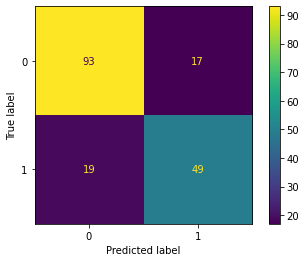

In [22]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_tree, X_test, y_test)

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.74      0.72      0.73        68

    accuracy                           0.80       178
   macro avg       0.79      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



In [24]:
Decision_tree_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))  

0.797752808988764


In [25]:
#Random Forest

In [26]:
train_forest = RandomForestClassifier(n_estimators=trees_in_forest, max_depth=tree_depth)
train_forest.fit(X_train, y_train.values.ravel())
train_forest.predict(test_set)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,

In [27]:
y_pred = train_forest.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.8448275862068966, 0.7205882352941176, 0.7777777777777778, None)


[[101   9]
 [ 19  49]]


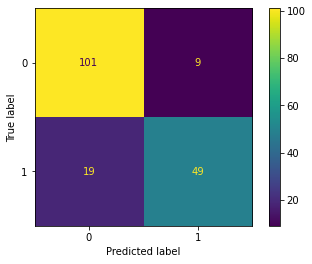

In [28]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_forest, X_test, y_test)

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       110
           1       0.84      0.72      0.78        68

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.83       178
weighted avg       0.84      0.84      0.84       178



In [30]:
Random_forest_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.8426966292134831


In [31]:
#Test with no family data, Decision Tree

In [32]:
train_set = data_prep_family_drop(train_set)
train_set

,Pclass,Sex,Age,Parch,Embarked
0,3,1,22,0,1
1,1,0,38,0,0
2,3,0,26,0,1
3,1,0,35,0,1
4,3,1,35,0,1
...,...,...,...,...,...
885,3,0,39,5,2
886,2,1,27,0,1
887,1,0,19,0,1
889,1,1,26,0,0


In [33]:
test_set = data_prep_family_drop(test_set)
test_set

,Pclass,Sex,Age,Parch,Embarked
0,3,1,34,0,2
1,3,0,47,0,1
2,2,1,62,0,2
3,3,1,27,0,1
4,3,0,22,1,1
...,...,...,...,...,...
409,3,0,3,1,1
411,1,0,37,0,2
412,3,0,28,0,1
414,1,0,39,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_set, train_set_survivors, test_size=0.25, random_state=7)
train_tree = tree.DecisionTreeClassifier(max_depth=tree_depth)
train_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7)

In [35]:
train_tree.predict(test_set)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [36]:
y_pred = train_tree.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7894736842105263, 0.6617647058823529, 0.72, None)


[[98 12]
 [23 45]]


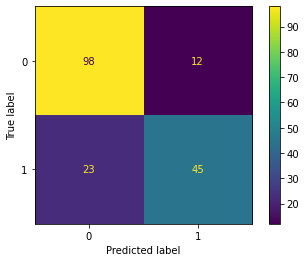

In [37]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_tree, X_test, y_test)

In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.66      0.72        68

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178



In [39]:
Decision_tree_no_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.8033707865168539


In [40]:
#Test with no family data, Random Forest

In [41]:
train_forest = RandomForestClassifier(n_estimators=trees_in_forest, max_depth=tree_depth)
train_forest.fit(X_train, y_train.values.ravel())
train_forest.predict(test_set)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [42]:
y_pred = train_forest.predict(X_test)
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))

(0.7962962962962963, 0.6323529411764706, 0.7049180327868853, None)


[[99 11]
 [25 43]]


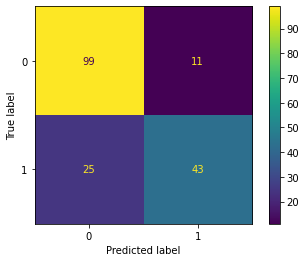

In [43]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(train_forest, X_test, y_test)

In [44]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.63      0.70        68

    accuracy                           0.80       178
   macro avg       0.80      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178



In [45]:
Random_forest_no_family = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.797752808988764


In [46]:
print('Accuracy of Decision Tree, taking family in account: ' + str(Decision_tree_family))
print('Accuracy of Random Forest, taking family in account: ' + str(Random_forest_family))
print('Accuracy of Decision Tree, not taking family in account: ' + str(Decision_tree_no_family))
print('Accuracy of Decision Tree, not taking family in account: ' + str(Random_forest_no_family))

Accuracy of Decision Tree, taking family in account: 0.797752808988764
Accuracy of Random Forest, taking family in account: 0.8426966292134831
Accuracy of Decision Tree, not taking family in account: 0.8033707865168539
Accuracy of Decision Tree, not taking family in account: 0.797752808988764


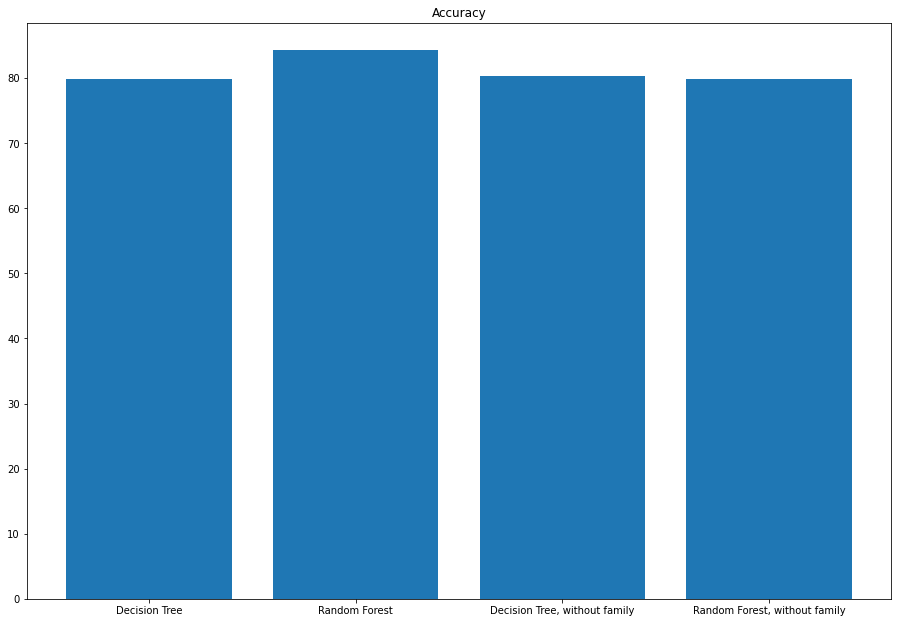

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
accuracy_labels = ['Decision Tree', 'Random Forest', 'Decision Tree, without family', 'Random Forest, without family']
accuracy_data = [Decision_tree_family*100,Random_forest_family*100,Decision_tree_no_family*100,Random_forest_no_family*100]
ax.bar(accuracy_labels,accuracy_data)
plt.title('Accuracy')
plt.show()

# Analiza i ocena wyników

Największą efektywność wykazał model 'Random Forest' z większą ilością danych. Model jest w stanie przewidzieć w 85%, to czy dany pasażer przeżył rejs Titaniciem. Jest on najskuteczniejszy, ponieważ zawiera w sobie 1000 różnych drzew, które wspólnie, na podstawie średnich wyników podejmują decyzję. Wariant z danymi bez informacji o rodzinie cechuje się mniejszą skutecznością, co sugeruje że jest to ważna kolumna.

In [48]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10000)


Epoch 1/10000
17/17 [==============================] - 2s 2ms/step - loss: 1.1906 - accuracy: 0.4759 
Epoch 2/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.7283 - accuracy: 0.5745
Epoch 3/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.6157 - accuracy: 0.6365
Epoch 4/10000
17/17 [==============================] - 0s 975us/step - loss: 0.7220 - accuracy: 0.5946
Epoch 5/10000
17/17 [==============================] - 0s 955us/step - loss: 0.6548 - accuracy: 0.6593
Epoch 6/10000
17/17 [==============================] - 0s 937us/step - loss: 0.6003 - accuracy: 0.6698
Epoch 7/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.5629 - accuracy: 0.7060
Epoch 8/10000
17/17 [==============================] - 0s 980us/step - loss: 0.6867 - accuracy: 0.6381
Epoch 9/10000
17/17 [==============================] - 0s 937us/step - loss: 0.5263 - accuracy: 0.7348
Epoch 10/10000
17/17 [==============================] - 0s 1000us/step - loss: 0

Epoch 80/10000
17/17 [==============================] - 0s 875us/step - loss: 0.3863 - accuracy: 0.8169
Epoch 81/10000
17/17 [==============================] - 0s 937us/step - loss: 0.4160 - accuracy: 0.8179
Epoch 82/10000
17/17 [==============================] - 0s 938us/step - loss: 0.4307 - accuracy: 0.8179
Epoch 83/10000
17/17 [==============================] - 0s 938us/step - loss: 0.3969 - accuracy: 0.8221
Epoch 84/10000
17/17 [==============================] - 0s 937us/step - loss: 0.4091 - accuracy: 0.8107
Epoch 85/10000
17/17 [==============================] - 0s 938us/step - loss: 0.3908 - accuracy: 0.8300
Epoch 86/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3861 - accuracy: 0.8320
Epoch 87/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3855 - accuracy: 0.8189
Epoch 88/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3991 - accuracy: 0.8261
Epoch 89/10000
17/17 [==============================] - 0s 938

17/17 [==============================] - 0s 938us/step - loss: 0.3768 - accuracy: 0.8418
Epoch 237/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3476 - accuracy: 0.8319
Epoch 238/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3894 - accuracy: 0.7821
Epoch 239/10000
17/17 [==============================] - 0s 938us/step - loss: 0.3866 - accuracy: 0.8193
Epoch 240/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3818 - accuracy: 0.8260
Epoch 241/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3235 - accuracy: 0.8487
Epoch 242/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3206 - accuracy: 0.8630
Epoch 243/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3165 - accuracy: 0.8447
Epoch 244/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3422 - accuracy: 0.8495
Epoch 245/10000
17/17 [==============================] - 0s 938us/st

17/17 [==============================] - 0s 1000us/step - loss: 0.3339 - accuracy: 0.8064
Epoch 392/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2665 - accuracy: 0.8836
Epoch 393/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3140 - accuracy: 0.8625
Epoch 394/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3505 - accuracy: 0.8292
Epoch 395/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3676 - accuracy: 0.8294
Epoch 396/10000
17/17 [==============================] - 0s 938us/step - loss: 0.3409 - accuracy: 0.8299
Epoch 397/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3618 - accuracy: 0.8335
Epoch 398/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3379 - accuracy: 0.8541
Epoch 399/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3388 - accuracy: 0.8361
Epoch 400/10000
17/17 [==============================] - 0s 1ms/step 

17/17 [==============================] - 0s 1000us/step - loss: 0.3156 - accuracy: 0.8516
Epoch 548/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3194 - accuracy: 0.8401
Epoch 549/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3248 - accuracy: 0.8478
Epoch 550/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2781 - accuracy: 0.8772
Epoch 551/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2746 - accuracy: 0.8854
Epoch 552/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3495 - accuracy: 0.8438
Epoch 553/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2945 - accuracy: 0.8529
Epoch 554/10000
17/17 [==============================] - 0s 970us/step - loss: 0.3180 - accuracy: 0.8480
Epoch 555/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2962 - accuracy: 0.8547
Epoch 556/10000
17/17 [==============================] - 0s 970us/s

17/17 [==============================] - 0s 938us/step - loss: 0.2838 - accuracy: 0.8692
Epoch 704/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2717 - accuracy: 0.8820
Epoch 705/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2857 - accuracy: 0.8629
Epoch 706/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2708 - accuracy: 0.8622
Epoch 707/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2989 - accuracy: 0.8522
Epoch 708/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2580 - accuracy: 0.8924
Epoch 709/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2683 - accuracy: 0.8779
Epoch 710/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3027 - accuracy: 0.8591
Epoch 711/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2755 - accuracy: 0.8795
Epoch 712/10000
17/17 [==============================] - 0s 938us/step

17/17 [==============================] - 0s 1000us/step - loss: 0.2693 - accuracy: 0.8659
Epoch 860/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2695 - accuracy: 0.8707
Epoch 861/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2618 - accuracy: 0.8687
Epoch 862/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3020 - accuracy: 0.8594
Epoch 863/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2737 - accuracy: 0.8662
Epoch 864/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2739 - accuracy: 0.8923
Epoch 865/10000
17/17 [==============================] - 0s 957us/step - loss: 0.3003 - accuracy: 0.8516
Epoch 866/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2904 - accuracy: 0.8455
Epoch 867/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2825 - accuracy: 0.8697
Epoch 868/10000
17/17 [==============================] - 0s 1ms/step - l

17/17 [==============================] - 0s 938us/step - loss: 0.2855 - accuracy: 0.8727
Epoch 1016/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2982 - accuracy: 0.8498
Epoch 1017/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2942 - accuracy: 0.8715
Epoch 1018/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2642 - accuracy: 0.8723
Epoch 1019/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2729 - accuracy: 0.8716
Epoch 1020/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2552 - accuracy: 0.8628
Epoch 1021/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2604 - accuracy: 0.8723
Epoch 1022/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2856 - accuracy: 0.8591
Epoch 1023/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3056 - accuracy: 0.8626
Epoch 1024/10000
17/17 [==============================] - 0s 10

17/17 [==============================] - 0s 875us/step - loss: 0.2554 - accuracy: 0.8915
Epoch 1170/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2517 - accuracy: 0.8727
Epoch 1171/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2352 - accuracy: 0.8884
Epoch 1172/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2363 - accuracy: 0.8897
Epoch 1173/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2537 - accuracy: 0.8886
Epoch 1174/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2706 - accuracy: 0.8557
Epoch 1175/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2802 - accuracy: 0.8634
Epoch 1176/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2686 - accuracy: 0.8857
Epoch 1177/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2807 - accuracy: 0.8659
Epoch 1178/10000
17/17 [==============================] - 0s 937us/step - los

17/17 [==============================] - 0s 937us/step - loss: 0.2611 - accuracy: 0.8812
Epoch 1324/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2764 - accuracy: 0.8818
Epoch 1325/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2256 - accuracy: 0.8984
Epoch 1326/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2445 - accuracy: 0.8776
Epoch 1327/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2413 - accuracy: 0.8852
Epoch 1328/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2448 - accuracy: 0.8941
Epoch 1329/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2560 - accuracy: 0.8731
Epoch 1330/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2554 - accuracy: 0.8799
Epoch 1331/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2787 - accuracy: 0.8766
Epoch 1332/10000
17/17 [==============================] - 0s 1ms/s

17/17 [==============================] - 0s 1ms/step - loss: 0.2546 - accuracy: 0.8755
Epoch 1478/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2170 - accuracy: 0.9127
Epoch 1479/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2812 - accuracy: 0.8597
Epoch 1480/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2623 - accuracy: 0.8892
Epoch 1481/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2830 - accuracy: 0.8559
Epoch 1482/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2617 - accuracy: 0.8842
Epoch 1483/10000
17/17 [==============================] - 0s 875us/step - loss: 0.3126 - accuracy: 0.8559
Epoch 1484/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2605 - accuracy: 0.9001
Epoch 1485/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2590 - accuracy: 0.8819
Epoch 1486/10000
17/17 [==============================] - 0s 937

17/17 [==============================] - 0s 1000us/step - loss: 0.2469 - accuracy: 0.8932
Epoch 1632/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2582 - accuracy: 0.8939
Epoch 1633/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2748 - accuracy: 0.8619
Epoch 1634/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2274 - accuracy: 0.8818
Epoch 1635/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2179 - accuracy: 0.8929
Epoch 1636/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2549 - accuracy: 0.8880
Epoch 1637/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2224 - accuracy: 0.9094
Epoch 1638/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2507 - accuracy: 0.8735
Epoch 1639/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2602 - accuracy: 0.8582
Epoch 1640/10000
17/17 [==============================] - 0s 937us/

17/17 [==============================] - 0s 1000us/step - loss: 0.3122 - accuracy: 0.8591
Epoch 1786/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.8885
Epoch 1787/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.8492
Epoch 1788/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2646 - accuracy: 0.8889
Epoch 1789/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2621 - accuracy: 0.8718
Epoch 1790/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2504 - accuracy: 0.8868
Epoch 1791/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2367 - accuracy: 0.8871
Epoch 1792/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2596 - accuracy: 0.8861
Epoch 1793/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2447 - accuracy: 0.8914
Epoch 1794/10000
17/17 [==============================] - 0s 937us/step 

17/17 [==============================] - 0s 1ms/step - loss: 0.2440 - accuracy: 0.8863
Epoch 1941/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.8810
Epoch 1942/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2274 - accuracy: 0.8744
Epoch 1943/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2610 - accuracy: 0.8575
Epoch 1944/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2166 - accuracy: 0.8942
Epoch 1945/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 0.8918
Epoch 1946/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2523 - accuracy: 0.8751
Epoch 1947/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2343 - accuracy: 0.8885
Epoch 1948/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2350 - accuracy: 0.8873
Epoch 1949/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2

17/17 [==============================] - 0s 1000us/step - loss: 0.3285 - accuracy: 0.8365
Epoch 2096/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2650 - accuracy: 0.8628
Epoch 2097/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2879 - accuracy: 0.8684
Epoch 2098/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2105 - accuracy: 0.9210
Epoch 2099/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2480 - accuracy: 0.8785
Epoch 2100/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2116 - accuracy: 0.9026
Epoch 2101/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2214 - accuracy: 0.9066
Epoch 2102/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2240 - accuracy: 0.8990
Epoch 2103/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9141
Epoch 2104/10000
17/17 [==============================] - 0s 1ms/s

17/17 [==============================] - 0s 1ms/step - loss: 0.2803 - accuracy: 0.8620
Epoch 2174/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2306 - accuracy: 0.8968
Epoch 2175/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2177 - accuracy: 0.9024
Epoch 2176/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2293 - accuracy: 0.8857
Epoch 2177/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.8693
Epoch 2178/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.9133
Epoch 2179/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2114 - accuracy: 0.9071
Epoch 2180/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2346 - accuracy: 0.8812
Epoch 2181/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2338 - accuracy: 0.8742
Epoch 2182/10000
17/17 [==============================] - 0s 1ms/step - loss: 

17/17 [==============================] - 0s 938us/step - loss: 0.2286 - accuracy: 0.8918
Epoch 2328/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2145 - accuracy: 0.8872
Epoch 2329/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2035 - accuracy: 0.8983
Epoch 2330/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2072 - accuracy: 0.9071
Epoch 2331/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2225 - accuracy: 0.8925
Epoch 2332/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2320 - accuracy: 0.8994
Epoch 2333/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2040 - accuracy: 0.8953
Epoch 2334/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2140 - accuracy: 0.8963
Epoch 2335/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2303 - accuracy: 0.8959
Epoch 2336/10000
17/17 [==============================] - 0s 

17/17 [==============================] - 0s 937us/step - loss: 0.1903 - accuracy: 0.9065
Epoch 2482/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2415 - accuracy: 0.8853
Epoch 2483/10000
17/17 [==============================] - 0s 940us/step - loss: 0.2225 - accuracy: 0.9053
Epoch 2484/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1670 - accuracy: 0.9154
Epoch 2485/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2007 - accuracy: 0.9086
Epoch 2486/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2058 - accuracy: 0.9070
Epoch 2487/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2144 - accuracy: 0.8864
Epoch 2488/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2160 - accuracy: 0.8940
Epoch 2489/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2658 - accuracy: 0.8716
Epoch 2490/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 937us/step - loss: 0.2690 - accuracy: 0.8730
Epoch 2636/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2972 - accuracy: 0.8840
Epoch 2637/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2462 - accuracy: 0.8705
Epoch 2638/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2004 - accuracy: 0.9161
Epoch 2639/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2186 - accuracy: 0.9028
Epoch 2640/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2151 - accuracy: 0.9016
Epoch 2641/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2150 - accuracy: 0.8955
Epoch 2642/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1975 - accuracy: 0.9088
Epoch 2643/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2630 - accuracy: 0.9023
Epoch 2644/10000
17/17 [==============================] - 0s 1ms/step 

17/17 [==============================] - 0s 937us/step - loss: 0.1992 - accuracy: 0.9139
Epoch 2790/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2131 - accuracy: 0.9077
Epoch 2791/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1880 - accuracy: 0.9049
Epoch 2792/10000
17/17 [==============================] - 0s 875us/step - loss: 0.1903 - accuracy: 0.9148
Epoch 2793/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2264 - accuracy: 0.8892
Epoch 2794/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2431 - accuracy: 0.9012
Epoch 2795/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2374 - accuracy: 0.8957
Epoch 2796/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1955 - accuracy: 0.9080
Epoch 2797/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2202 - accuracy: 0.8711
Epoch 2798/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 938us/step - loss: 0.2196 - accuracy: 0.8881
Epoch 2944/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2549 - accuracy: 0.8817
Epoch 2945/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2134 - accuracy: 0.9153
Epoch 2946/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2297 - accuracy: 0.8891
Epoch 2947/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2114 - accuracy: 0.8838
Epoch 2948/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2248 - accuracy: 0.8893
Epoch 2949/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2050 - accuracy: 0.9121
Epoch 2950/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1935 - accuracy: 0.9184
Epoch 2951/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1936 - accuracy: 0.9273
Epoch 2952/10000
17/17 [==============================] - 0s 938us/

17/17 [==============================] - 0s 1ms/step - loss: 0.2058 - accuracy: 0.9019
Epoch 3098/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2045 - accuracy: 0.8988
Epoch 3099/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9111
Epoch 3100/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1842 - accuracy: 0.9012
Epoch 3101/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1820 - accuracy: 0.9164
Epoch 3102/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1887 - accuracy: 0.9016
Epoch 3103/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1703 - accuracy: 0.9218
Epoch 3104/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1816 - accuracy: 0.9074
Epoch 3105/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1734 - accuracy: 0.9307
Epoch 3106/10000
17/17 [==============================] - 0s 1000us/step - l

17/17 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.9042
Epoch 3254/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2676 - accuracy: 0.8630
Epoch 3255/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2192 - accuracy: 0.9002
Epoch 3256/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2029 - accuracy: 0.9098
Epoch 3257/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1798 - accuracy: 0.9152
Epoch 3258/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1842 - accuracy: 0.8942
Epoch 3259/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.9060
Epoch 3260/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1747 - accuracy: 0.9292
Epoch 3261/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2010 - accuracy: 0.9140
Epoch 3262/10000
17/17 [==============================] - 0s 1ms/step -

17/17 [==============================] - 0s 1ms/step - loss: 0.2377 - accuracy: 0.8834
Epoch 3409/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.9079
Epoch 3410/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1914 - accuracy: 0.9179
Epoch 3411/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2099 - accuracy: 0.9033
Epoch 3412/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1993 - accuracy: 0.8989
Epoch 3413/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2102 - accuracy: 0.8957
Epoch 3414/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2172 - accuracy: 0.8906
Epoch 3415/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2103 - accuracy: 0.9095
Epoch 3416/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3231 - accuracy: 0.8613
Epoch 3417/10000
17/17 [==============================] - 0s 1ms/ste

17/17 [==============================] - 0s 1000us/step - loss: 0.1980 - accuracy: 0.9014
Epoch 3563/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1921 - accuracy: 0.8998
Epoch 3564/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1780 - accuracy: 0.9118
Epoch 3565/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1871 - accuracy: 0.9062
Epoch 3566/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1969 - accuracy: 0.8984
Epoch 3567/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9030
Epoch 3568/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2238 - accuracy: 0.9096
Epoch 3569/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9051
Epoch 3570/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1939 - accuracy: 0.9144
Epoch 3571/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 938us/step - loss: 0.1705 - accuracy: 0.9133
Epoch 3717/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1975 - accuracy: 0.8957
Epoch 3718/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1671 - accuracy: 0.9297
Epoch 3719/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1538 - accuracy: 0.9346
Epoch 3720/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1810 - accuracy: 0.9166
Epoch 3721/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1515 - accuracy: 0.9239
Epoch 3722/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1651 - accuracy: 0.9227
Epoch 3723/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.9278
Epoch 3724/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1668 - accuracy: 0.8968
Epoch 3725/10000
17/17 [==============================] - 0s 1000

17/17 [==============================] - 0s 1ms/step - loss: 0.1972 - accuracy: 0.9035
Epoch 3871/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1836 - accuracy: 0.9195
Epoch 3872/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1792 - accuracy: 0.9166
Epoch 3873/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1966 - accuracy: 0.8987
Epoch 3874/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1878 - accuracy: 0.9076
Epoch 3875/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1965 - accuracy: 0.9025
Epoch 3876/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1636 - accuracy: 0.9195
Epoch 3877/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1794 - accuracy: 0.9226
Epoch 3878/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2170 - accuracy: 0.8867
Epoch 3879/10000
17/17 [==============================] - 0s 937us/step 

17/17 [==============================] - 0s 937us/step - loss: 0.2081 - accuracy: 0.8986
Epoch 4025/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1695 - accuracy: 0.9146
Epoch 4026/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2506 - accuracy: 0.8869
Epoch 4027/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2157 - accuracy: 0.9001
Epoch 4028/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2196 - accuracy: 0.8923
Epoch 4029/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2170 - accuracy: 0.8976
Epoch 4030/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2596 - accuracy: 0.8924
Epoch 4031/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2079 - accuracy: 0.8910
Epoch 4032/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2155 - accuracy: 0.8949
Epoch 4033/10000
17/17 [==============================] - 0s 937us/s

17/17 [==============================] - 0s 875us/step - loss: 0.2199 - accuracy: 0.8987
Epoch 4179/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1938 - accuracy: 0.9154
Epoch 4180/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1857 - accuracy: 0.9170
Epoch 4181/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1924 - accuracy: 0.9121
Epoch 4182/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1792 - accuracy: 0.9155
Epoch 4183/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1752 - accuracy: 0.9114
Epoch 4184/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1618 - accuracy: 0.9202
Epoch 4185/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1633 - accuracy: 0.9308
Epoch 4186/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1900 - accuracy: 0.9059
Epoch 4187/10000
17/17 [==============================] - 0s 1000us/s

Epoch 4256/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1465 - accuracy: 0.9385
Epoch 4257/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2007 - accuracy: 0.9012
Epoch 4258/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1604 - accuracy: 0.9305
Epoch 4259/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1548 - accuracy: 0.9390
Epoch 4260/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1526 - accuracy: 0.9363
Epoch 4261/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1723 - accuracy: 0.9120
Epoch 4262/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1532 - accuracy: 0.9334
Epoch 4263/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1484 - accuracy: 0.9266
Epoch 4264/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1941 - accuracy: 0.8896
Epoch 4265/10000
17/17 [=============================

17/17 [==============================] - 0s 1ms/step - loss: 0.1912 - accuracy: 0.8953
Epoch 4411/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1794 - accuracy: 0.9119
Epoch 4412/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1811 - accuracy: 0.9038
Epoch 4413/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1587 - accuracy: 0.9184
Epoch 4414/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1637 - accuracy: 0.9258
Epoch 4415/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1815 - accuracy: 0.8873
Epoch 4416/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1802 - accuracy: 0.9170
Epoch 4417/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.9201
Epoch 4418/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1682 - accuracy: 0.9153
Epoch 4419/10000
17/17 [==============================] - 0s 1000us/step - l

17/17 [==============================] - 0s 1ms/step - loss: 0.2225 - accuracy: 0.8971
Epoch 4489/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.9148
Epoch 4490/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2343 - accuracy: 0.8770
Epoch 4491/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2280 - accuracy: 0.8873
Epoch 4492/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1961 - accuracy: 0.8978
Epoch 4493/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1899 - accuracy: 0.9148
Epoch 4494/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2187 - accuracy: 0.9067
Epoch 4495/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1815 - accuracy: 0.9182
Epoch 4496/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1925 - accuracy: 0.9047
Epoch 4497/10000
17/17 [==============================] - 0s 1ms/step - los

17/17 [==============================] - 0s 1ms/step - loss: 0.2016 - accuracy: 0.9081
Epoch 4645/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1841 - accuracy: 0.9127
Epoch 4646/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2188 - accuracy: 0.8912
Epoch 4647/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1709 - accuracy: 0.9250
Epoch 4648/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9026
Epoch 4649/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2885 - accuracy: 0.8650
Epoch 4650/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3266 - accuracy: 0.8572
Epoch 4651/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3063 - accuracy: 0.8859
Epoch 4652/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3837 - accuracy: 0.8737
Epoch 4653/10000
17/17 [==============================] - 0s 1ms/step - los

17/17 [==============================] - 0s 1ms/step - loss: 0.3528 - accuracy: 0.8544
Epoch 4801/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2755 - accuracy: 0.8857
Epoch 4802/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2586 - accuracy: 0.8726
Epoch 4803/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2481 - accuracy: 0.8833
Epoch 4804/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2180 - accuracy: 0.9074
Epoch 4805/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2060 - accuracy: 0.9148
Epoch 4806/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2050 - accuracy: 0.9060
Epoch 4807/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2020 - accuracy: 0.8954
Epoch 4808/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2082 - accuracy: 0.9004
Epoch 4809/10000
17/17 [==============================] - 0s 1ms/step 

17/17 [==============================] - 0s 1ms/step - loss: 0.1955 - accuracy: 0.9022
Epoch 4879/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1689 - accuracy: 0.9146
Epoch 4880/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1714 - accuracy: 0.9045
Epoch 4881/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.8907
Epoch 4882/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1677 - accuracy: 0.9237
Epoch 4883/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1712 - accuracy: 0.9229
Epoch 4884/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.8849
Epoch 4885/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1713 - accuracy: 0.9167
Epoch 4886/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1556 - accuracy: 0.9330
Epoch 4887/10000
17/17 [==============================] - 0s 937us/step - loss

17/17 [==============================] - 0s 1ms/step - loss: 0.1926 - accuracy: 0.9047
Epoch 4957/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1876 - accuracy: 0.9147
Epoch 4958/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1664 - accuracy: 0.9275
Epoch 4959/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1967 - accuracy: 0.9173
Epoch 4960/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2077 - accuracy: 0.8977
Epoch 4961/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1792 - accuracy: 0.9202
Epoch 4962/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2044 - accuracy: 0.8963
Epoch 4963/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2491 - accuracy: 0.8784
Epoch 4964/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2248 - accuracy: 0.8991
Epoch 4965/10000
17/17 [==============================] - 0s 1000us/

17/17 [==============================] - 0s 1ms/step - loss: 0.1823 - accuracy: 0.9087
Epoch 5111/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.9076
Epoch 5112/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1985 - accuracy: 0.9151
Epoch 5113/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1841 - accuracy: 0.9113
Epoch 5114/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1830 - accuracy: 0.9239
Epoch 5115/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1806 - accuracy: 0.9086
Epoch 5116/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1941 - accuracy: 0.9056
Epoch 5117/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1715 - accuracy: 0.9175
Epoch 5118/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1648 - accuracy: 0.9024
Epoch 5119/10000
17/17 [==============================] - 0s 937us/ste

17/17 [==============================] - 0s 937us/step - loss: 0.1517 - accuracy: 0.9274
Epoch 5265/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9310
Epoch 5266/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1621 - accuracy: 0.9213
Epoch 5267/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1662 - accuracy: 0.9172
Epoch 5268/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1554 - accuracy: 0.9311
Epoch 5269/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1934 - accuracy: 0.9045
Epoch 5270/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1692 - accuracy: 0.9170
Epoch 5271/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1596 - accuracy: 0.9302
Epoch 5272/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1680 - accuracy: 0.9215
Epoch 5273/10000
17/17 [==============================] - 0s 938us/st

17/17 [==============================] - 0s 1ms/step - loss: 0.1669 - accuracy: 0.9249
Epoch 5419/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1600 - accuracy: 0.9184
Epoch 5420/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.9279
Epoch 5421/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1771 - accuracy: 0.9185
Epoch 5422/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1763 - accuracy: 0.9141
Epoch 5423/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1603 - accuracy: 0.9119
Epoch 5424/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1651 - accuracy: 0.9275
Epoch 5425/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2083 - accuracy: 0.8952
Epoch 5426/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2133 - accuracy: 0.8952
Epoch 5427/10000
17/17 [==============================] - 0s 1000us

17/17 [==============================] - 0s 1000us/step - loss: 0.1777 - accuracy: 0.9130
Epoch 5573/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.9174
Epoch 5574/10000
17/17 [==============================] - 0s 948us/step - loss: 0.1676 - accuracy: 0.9237
Epoch 5575/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1739 - accuracy: 0.9167
Epoch 5576/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2025 - accuracy: 0.9130
Epoch 5577/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1605 - accuracy: 0.9289
Epoch 5578/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1599 - accuracy: 0.9267
Epoch 5579/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2341 - accuracy: 0.9075
Epoch 5580/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2522 - accuracy: 0.8930
Epoch 5581/10000
17/17 [==============================] - 0s 1000u

17/17 [==============================] - 0s 1ms/step - loss: 0.1497 - accuracy: 0.9258
Epoch 5651/10000
17/17 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9323
Epoch 5652/10000
17/17 [==============================] - 0s 2ms/step - loss: 0.1602 - accuracy: 0.9321
Epoch 5653/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1668 - accuracy: 0.9119
Epoch 5654/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.9271
Epoch 5655/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1384 - accuracy: 0.9436
Epoch 5656/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.8960
Epoch 5657/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1812 - accuracy: 0.9140
Epoch 5658/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1543 - accuracy: 0.9254
Epoch 5659/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1

Epoch 5806/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1693 - accuracy: 0.9066
Epoch 5807/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1596 - accuracy: 0.9229
Epoch 5808/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1764 - accuracy: 0.9057
Epoch 5809/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1620 - accuracy: 0.9120
Epoch 5810/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1454 - accuracy: 0.9273
Epoch 5811/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9227
Epoch 5812/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1494 - accuracy: 0.9373
Epoch 5813/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1376 - accuracy: 0.9293
Epoch 5814/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1719 - accuracy: 0.9115
Epoch 5815/10000
17/17 [========================

17/17 [==============================] - 0s 1000us/step - loss: 0.1548 - accuracy: 0.9180
Epoch 5961/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1516 - accuracy: 0.9136
Epoch 5962/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1811 - accuracy: 0.9015
Epoch 5963/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1703 - accuracy: 0.9133
Epoch 5964/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9200
Epoch 5965/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 0.9069
Epoch 5966/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1502 - accuracy: 0.9206
Epoch 5967/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1647 - accuracy: 0.9226
Epoch 5968/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1716 - accuracy: 0.8969
Epoch 5969/10000
17/17 [==============================] - 0s 1000us

17/17 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.9212
Epoch 6115/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1519 - accuracy: 0.9312
Epoch 6116/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.8949
Epoch 6117/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1558 - accuracy: 0.9263
Epoch 6118/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.9236
Epoch 6119/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.9235
Epoch 6120/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1708 - accuracy: 0.9190
Epoch 6121/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1624 - accuracy: 0.9238
Epoch 6122/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1262 - accuracy: 0.9347
Epoch 6123/10000
17/17 [==============================] - 0s 1000us/step - los

17/17 [==============================] - 0s 1ms/step - loss: 0.2073 - accuracy: 0.9166
Epoch 6271/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1823 - accuracy: 0.8895
Epoch 6272/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1555 - accuracy: 0.9191
Epoch 6273/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1888 - accuracy: 0.9117
Epoch 6274/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1632 - accuracy: 0.9148
Epoch 6275/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1424 - accuracy: 0.9197
Epoch 6276/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1468 - accuracy: 0.9222
Epoch 6277/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1632 - accuracy: 0.9224
Epoch 6278/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1688 - accuracy: 0.9215
Epoch 6279/10000
17/17 [==============================] - 0s 1000us/step 

Epoch 6348/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1351 - accuracy: 0.9335
Epoch 6349/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1456 - accuracy: 0.9353
Epoch 6350/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.9269
Epoch 6351/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1490 - accuracy: 0.9190
Epoch 6352/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9173
Epoch 6353/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1529 - accuracy: 0.9242
Epoch 6354/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1441 - accuracy: 0.9340
Epoch 6355/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1481 - accuracy: 0.9225
Epoch 6356/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1760 - accuracy: 0.9107
Epoch 6357/10000
17/17 [==============================] - 0

Epoch 6426/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1528 - accuracy: 0.9224
Epoch 6427/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1413 - accuracy: 0.9281
Epoch 6428/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1625 - accuracy: 0.9228
Epoch 6429/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1602 - accuracy: 0.9219
Epoch 6430/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1286 - accuracy: 0.9475
Epoch 6431/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1924 - accuracy: 0.9105
Epoch 6432/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1463 - accuracy: 0.9297
Epoch 6433/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.8872
Epoch 6434/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1889 - accuracy: 0.8948
Epoch 6435/10000
17/17 [====================

17/17 [==============================] - 0s 937us/step - loss: 0.1778 - accuracy: 0.9096
Epoch 6582/10000
17/17 [==============================] - 0s 913us/step - loss: 0.1611 - accuracy: 0.9286
Epoch 6583/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1773 - accuracy: 0.9168
Epoch 6584/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1900 - accuracy: 0.9163
Epoch 6585/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1822 - accuracy: 0.9176
Epoch 6586/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1957 - accuracy: 0.9088
Epoch 6587/10000
17/17 [==============================] - 0s 875us/step - loss: 0.1588 - accuracy: 0.9287
Epoch 6588/10000
17/17 [==============================] - 0s 928us/step - loss: 0.1788 - accuracy: 0.9207
Epoch 6589/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1654 - accuracy: 0.9164
Epoch 6590/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 1000us/step - loss: 0.1459 - accuracy: 0.9317
Epoch 6736/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1433 - accuracy: 0.9287
Epoch 6737/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1628 - accuracy: 0.9044
Epoch 6738/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1753 - accuracy: 0.9084
Epoch 6739/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1665 - accuracy: 0.9204
Epoch 6740/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1661 - accuracy: 0.9142
Epoch 6741/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1460 - accuracy: 0.9248
Epoch 6742/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1671 - accuracy: 0.9169
Epoch 6743/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1657 - accuracy: 0.9106
Epoch 6744/10000
17/17 [==============================] - 0s 1ms/step - los

17/17 [==============================] - 0s 937us/step - loss: 0.1723 - accuracy: 0.9050
Epoch 6890/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1826 - accuracy: 0.8958
Epoch 6891/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1368 - accuracy: 0.9407
Epoch 6892/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1599 - accuracy: 0.9170
Epoch 6893/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1569 - accuracy: 0.9274
Epoch 6894/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1766 - accuracy: 0.9206
Epoch 6895/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2232 - accuracy: 0.9098
Epoch 6896/10000
17/17 [==============================] - 0s 875us/step - loss: 0.2043 - accuracy: 0.9067
Epoch 6897/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1944 - accuracy: 0.9160
Epoch 6898/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 1000us/step - loss: 0.1556 - accuracy: 0.9159
Epoch 7044/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1947 - accuracy: 0.8894
Epoch 7045/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1644 - accuracy: 0.9071
Epoch 7046/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1979 - accuracy: 0.9018
Epoch 7047/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1859 - accuracy: 0.9156
Epoch 7048/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1876 - accuracy: 0.9021
Epoch 7049/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1624 - accuracy: 0.9163
Epoch 7050/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1796 - accuracy: 0.8985
Epoch 7051/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1636 - accuracy: 0.9128
Epoch 7052/10000
17/17 [==============================] - 0s 1ms/

17/17 [==============================] - 0s 1ms/step - loss: 0.1615 - accuracy: 0.9120
Epoch 7199/10000
17/17 [==============================] - 0s 908us/step - loss: 0.1882 - accuracy: 0.8986
Epoch 7200/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1396 - accuracy: 0.9117
Epoch 7201/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1656 - accuracy: 0.9064
Epoch 7202/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1819 - accuracy: 0.9016
Epoch 7203/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1648 - accuracy: 0.9154
Epoch 7204/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1625 - accuracy: 0.9166
Epoch 7205/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1740 - accuracy: 0.9208
Epoch 7206/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1525 - accuracy: 0.9189
Epoch 7207/10000
17/17 [==============================] - 0s 1ms/step -

17/17 [==============================] - 0s 1000us/step - loss: 0.1676 - accuracy: 0.9191
Epoch 7277/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1904 - accuracy: 0.9068
Epoch 7278/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1488 - accuracy: 0.9351
Epoch 7279/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1557 - accuracy: 0.9318
Epoch 7280/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1763 - accuracy: 0.9040
Epoch 7281/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1830 - accuracy: 0.9091
Epoch 7282/10000
17/17 [==============================] - 0s 922us/step - loss: 0.1557 - accuracy: 0.9301
Epoch 7283/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1458 - accuracy: 0.9341
Epoch 7284/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1574 - accuracy: 0.9227
Epoch 7285/10000
17/17 [==============================] - 0s 937u

17/17 [==============================] - 0s 970us/step - loss: 0.1739 - accuracy: 0.9167
Epoch 7431/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1596 - accuracy: 0.9290
Epoch 7432/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1341 - accuracy: 0.9282
Epoch 7433/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1428 - accuracy: 0.9316
Epoch 7434/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1536 - accuracy: 0.9290
Epoch 7435/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9205
Epoch 7436/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1561 - accuracy: 0.9317
Epoch 7437/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1624 - accuracy: 0.9344
Epoch 7438/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1524 - accuracy: 0.9183
Epoch 7439/10000
17/17 [==============================] - 0s 970us/st

17/17 [==============================] - 0s 1ms/step - loss: 0.1933 - accuracy: 0.9149
Epoch 7585/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1714 - accuracy: 0.9194
Epoch 7586/10000
17/17 [==============================] - 0s 977us/step - loss: 0.1834 - accuracy: 0.9012
Epoch 7587/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1854 - accuracy: 0.9032
Epoch 7588/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1697 - accuracy: 0.9225
Epoch 7589/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2384 - accuracy: 0.8868
Epoch 7590/10000
17/17 [==============================] - 0s 972us/step - loss: 0.2751 - accuracy: 0.8962
Epoch 7591/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2112 - accuracy: 0.9103
Epoch 7592/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2296 - accuracy: 0.8943
Epoch 7593/10000
17/17 [==============================] - 0s 93

17/17 [==============================] - 0s 937us/step - loss: 0.2124 - accuracy: 0.9084
Epoch 7739/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1732 - accuracy: 0.9247
Epoch 7740/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1870 - accuracy: 0.9119
Epoch 7741/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1666 - accuracy: 0.9339
Epoch 7742/10000
17/17 [==============================] - 0s 884us/step - loss: 0.2085 - accuracy: 0.8924
Epoch 7743/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1706 - accuracy: 0.9153
Epoch 7744/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1728 - accuracy: 0.9178
Epoch 7745/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1504 - accuracy: 0.9295
Epoch 7746/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1472 - accuracy: 0.9263
Epoch 7747/10000
17/17 [==============================] - 0s 970us/

17/17 [==============================] - 0s 1000us/step - loss: 0.1456 - accuracy: 0.9253
Epoch 7893/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1304 - accuracy: 0.9387
Epoch 7894/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1386 - accuracy: 0.9333
Epoch 7895/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1439 - accuracy: 0.9305
Epoch 7896/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1472 - accuracy: 0.9313
Epoch 7897/10000
17/17 [==============================] - 0s 978us/step - loss: 0.1461 - accuracy: 0.9276
Epoch 7898/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1770 - accuracy: 0.9117
Epoch 7899/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1564 - accuracy: 0.9185
Epoch 7900/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1498 - accuracy: 0.9297
Epoch 7901/10000
17/17 [==============================] - 0s

17/17 [==============================] - 0s 938us/step - loss: 0.1574 - accuracy: 0.9240
Epoch 8047/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1742 - accuracy: 0.8857
Epoch 8048/10000
17/17 [==============================] - 0s 943us/step - loss: 0.1274 - accuracy: 0.9393
Epoch 8049/10000
17/17 [==============================] - 0s 998us/step - loss: 0.1623 - accuracy: 0.9091
Epoch 8050/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1395 - accuracy: 0.9305
Epoch 8051/10000
17/17 [==============================] - 0s 875us/step - loss: 0.1735 - accuracy: 0.9075
Epoch 8052/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1625 - accuracy: 0.9324
Epoch 8053/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2097 - accuracy: 0.8970
Epoch 8054/10000
17/17 [==============================] - 0s 938us/step - loss: 0.3538 - accuracy: 0.8623
Epoch 8055/10000
17/17 [==============================] - 0s 

17/17 [==============================] - 0s 970us/step - loss: 0.1725 - accuracy: 0.9190
Epoch 8201/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1590 - accuracy: 0.9148
Epoch 8202/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1704 - accuracy: 0.9194
Epoch 8203/10000
17/17 [==============================] - 0s 908us/step - loss: 0.1649 - accuracy: 0.9212
Epoch 8204/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1613 - accuracy: 0.9072
Epoch 8205/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1534 - accuracy: 0.9080
Epoch 8206/10000
17/17 [==============================] - 0s 907us/step - loss: 0.1574 - accuracy: 0.9096
Epoch 8207/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1520 - accuracy: 0.9229
Epoch 8208/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1492 - accuracy: 0.9193
Epoch 8209/10000
17/17 [==============================] - 0s 938us

17/17 [==============================] - 0s 970us/step - loss: 0.1705 - accuracy: 0.9164
Epoch 8355/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1796 - accuracy: 0.9012
Epoch 8356/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1802 - accuracy: 0.9197
Epoch 8357/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1769 - accuracy: 0.9041
Epoch 8358/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2385 - accuracy: 0.8867
Epoch 8359/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2107 - accuracy: 0.9024
Epoch 8360/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1912 - accuracy: 0.9045
Epoch 8361/10000
17/17 [==============================] - 0s 970us/step - loss: 0.2167 - accuracy: 0.9050
Epoch 8362/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2017 - accuracy: 0.8938
Epoch 8363/10000
17/17 [==============================] - 0s 970u

17/17 [==============================] - 0s 937us/step - loss: 0.4656 - accuracy: 0.8195
Epoch 8509/10000
17/17 [==============================] - 0s 937us/step - loss: 0.3253 - accuracy: 0.8449
Epoch 8510/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2382 - accuracy: 0.8740
Epoch 8511/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.8905
Epoch 8512/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2197 - accuracy: 0.9021
Epoch 8513/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2118 - accuracy: 0.8856
Epoch 8514/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1841 - accuracy: 0.9078
Epoch 8515/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1683 - accuracy: 0.9091
Epoch 8516/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1686 - accuracy: 0.9024
Epoch 8517/10000
17/17 [==============================] - 0s 1ms

17/17 [==============================] - 0s 1000us/step - loss: 0.1953 - accuracy: 0.9098
Epoch 8663/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1801 - accuracy: 0.9043
Epoch 8664/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1807 - accuracy: 0.9203
Epoch 8665/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1604 - accuracy: 0.9246
Epoch 8666/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1852 - accuracy: 0.9014
Epoch 8667/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1594 - accuracy: 0.9186
Epoch 8668/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1402 - accuracy: 0.9424
Epoch 8669/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1705 - accuracy: 0.9128
Epoch 8670/10000
17/17 [==============================] - 0s 908us/step - loss: 0.1611 - accuracy: 0.9241
Epoch 8671/10000
17/17 [==============================] - 0s

17/17 [==============================] - 0s 1ms/step - loss: 0.1683 - accuracy: 0.9059
Epoch 8817/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1448 - accuracy: 0.9214
Epoch 8818/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1714 - accuracy: 0.9004
Epoch 8819/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1565 - accuracy: 0.9179
Epoch 8820/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1582 - accuracy: 0.9066
Epoch 8821/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1630 - accuracy: 0.9115
Epoch 8822/10000
17/17 [==============================] - 0s 971us/step - loss: 0.1686 - accuracy: 0.9089
Epoch 8823/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1790 - accuracy: 0.9039
Epoch 8824/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1624 - accuracy: 0.9101
Epoch 8825/10000
17/17 [==============================] - 0s 10

Epoch 8971/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.9058
Epoch 8972/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1394 - accuracy: 0.9223
Epoch 8973/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1783 - accuracy: 0.9139
Epoch 8974/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1669 - accuracy: 0.9264
Epoch 8975/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1679 - accuracy: 0.9131
Epoch 8976/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1820 - accuracy: 0.8972
Epoch 8977/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1683 - accuracy: 0.9147
Epoch 8978/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1722 - accuracy: 0.9047
Epoch 8979/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1933 - accuracy: 0.8993
Epoch 8980/10000
17/17 [=============================

17/17 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.9102
Epoch 9126/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2140 - accuracy: 0.9002
Epoch 9127/10000
17/17 [==============================] - 0s 940us/step - loss: 0.2298 - accuracy: 0.8961
Epoch 9128/10000
17/17 [==============================] - 0s 970us/step - loss: 0.3267 - accuracy: 0.8627
Epoch 9129/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.5233 - accuracy: 0.8668
Epoch 9130/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.8309
Epoch 9131/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.3791 - accuracy: 0.8215
Epoch 9132/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3022 - accuracy: 0.8573
Epoch 9133/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2506 - accuracy: 0.8886
Epoch 9134/10000
17/17 [==============================] - 0s 1000us/step -

Epoch 9203/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1533 - accuracy: 0.9256
Epoch 9204/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1707 - accuracy: 0.9087
Epoch 9205/10000
17/17 [==============================] - 0s 973us/step - loss: 0.1804 - accuracy: 0.9059
Epoch 9206/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.9294
Epoch 9207/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1713 - accuracy: 0.9165
Epoch 9208/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1731 - accuracy: 0.8973
Epoch 9209/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1505 - accuracy: 0.9289
Epoch 9210/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.8972
Epoch 9211/10000
17/17 [==============================] - 0s 999us/step - loss: 0.1356 - accuracy: 0.9331
Epoch 9212/10000
17/17 [============================

17/17 [==============================] - 0s 937us/step - loss: 0.1693 - accuracy: 0.9235
Epoch 9358/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1862 - accuracy: 0.9049
Epoch 9359/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1611 - accuracy: 0.9194
Epoch 9360/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2042 - accuracy: 0.8968
Epoch 9361/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1869 - accuracy: 0.9175
Epoch 9362/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1966 - accuracy: 0.9094
Epoch 9363/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2176 - accuracy: 0.9038
Epoch 9364/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1960 - accuracy: 0.9154
Epoch 9365/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1850 - accuracy: 0.9244
Epoch 9366/10000
17/17 [==============================] - 0s 937us/

17/17 [==============================] - 0s 1000us/step - loss: 0.1497 - accuracy: 0.9277
Epoch 9512/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1562 - accuracy: 0.9256
Epoch 9513/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1536 - accuracy: 0.9374
Epoch 9514/10000
17/17 [==============================] - 0s 978us/step - loss: 0.1831 - accuracy: 0.9160
Epoch 9515/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1821 - accuracy: 0.9208
Epoch 9516/10000
17/17 [==============================] - 0s 937us/step - loss: 0.2137 - accuracy: 0.8846
Epoch 9517/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1948 - accuracy: 0.9132
Epoch 9518/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1516 - accuracy: 0.9320
Epoch 9519/10000
17/17 [==============================] - 0s 938us/step - loss: 0.2504 - accuracy: 0.8787
Epoch 9520/10000
17/17 [==============================] - 0s 

17/17 [==============================] - 0s 970us/step - loss: 0.1722 - accuracy: 0.9181
Epoch 9666/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1855 - accuracy: 0.9068
Epoch 9667/10000
17/17 [==============================] - 0s 970us/step - loss: 0.1841 - accuracy: 0.9024
Epoch 9668/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1721 - accuracy: 0.9159
Epoch 9669/10000
17/17 [==============================] - 0s 970us/step - loss: 0.2031 - accuracy: 0.8991
Epoch 9670/10000
17/17 [==============================] - 0s 908us/step - loss: 0.1792 - accuracy: 0.9212
Epoch 9671/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1780 - accuracy: 0.9074
Epoch 9672/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1848 - accuracy: 0.8952
Epoch 9673/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1708 - accuracy: 0.9224
Epoch 9674/10000
17/17 [==============================] - 0s 1ms/step - l

17/17 [==============================] - 0s 1ms/step - loss: 0.2809 - accuracy: 0.8903
Epoch 9820/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.3059 - accuracy: 0.8629
Epoch 9821/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.2158 - accuracy: 0.8775
Epoch 9822/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.2039 - accuracy: 0.9079
Epoch 9823/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1918 - accuracy: 0.9110
Epoch 9824/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1615 - accuracy: 0.9145
Epoch 9825/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1647 - accuracy: 0.9132
Epoch 9826/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1782 - accuracy: 0.9051
Epoch 9827/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1681 - accuracy: 0.9008
Epoch 9828/10000
17/17 [==============================] - 0s 1000us/step 

17/17 [==============================] - 0s 938us/step - loss: 0.1707 - accuracy: 0.9168
Epoch 9974/10000
17/17 [==============================] - 0s 973us/step - loss: 0.1698 - accuracy: 0.9122
Epoch 9975/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1899 - accuracy: 0.9096
Epoch 9976/10000
17/17 [==============================] - 0s 1ms/step - loss: 0.1677 - accuracy: 0.9260
Epoch 9977/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1697 - accuracy: 0.9121
Epoch 9978/10000
17/17 [==============================] - 0s 1000us/step - loss: 0.1533 - accuracy: 0.9169
Epoch 9979/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1711 - accuracy: 0.9058
Epoch 9980/10000
17/17 [==============================] - 0s 938us/step - loss: 0.1360 - accuracy: 0.9308
Epoch 9981/10000
17/17 [==============================] - 0s 937us/step - loss: 0.1720 - accuracy: 0.9209
Epoch 9982/10000
17/17 [==============================] - 0s 970u

In [49]:
val_loss, val_acc = model.evaluate(X_test, y_test)  # evaluate the out of sample data with model
print(val_loss)  # model's loss (error)
print(val_acc)  # model's accuracy

6/6 [==============================] - 0s 800us/step - loss: 4.4220 - accuracy: 0.7640
4.4220075607299805
0.7640449404716492
